In [1]:
!curl -LsSf https://astral.sh/uv/install.sh | sh

downloading uv 0.9.0 x86_64-unknown-linux-gnu
no checksums to verify
installing to /usr/local/bin
  uv
  uvx
everything's installed!


In [2]:
!uv pip install torch torchvision matplotlib transformers

Using Python 3.11.13 environment at: /usr
Resolved 59 packages in 499ms
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
Prepared 1 package in 104ms
Uninstalled 11 packages in 116ms
Installed 11 packages in 19.58s
 - huggingface-hub==1.0.0rc2
 + huggingface-hub==0.35.3
 - nvidia-cublas-cu12==12.5.3.2
 + nvidia-cublas-cu12==12.4.5.8
 - nvidia-cuda-cupti-cu12==12.5.82
 + nvidia-cuda-cupti-cu12==12.4.127
 - nvidia-cuda-nvrtc-cu12==12.5.82
 + nvidia-cuda-nvrtc-cu12==12.4.127
 - 

In [3]:
from torchvision.datasets import DatasetFolder, ImageFolder
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch

from transformers import CLIPTokenizerFast

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

from pathlib import Path
import time
import os

### Global Paths

In [4]:
# Disabiling the Tokenizer Parallelism to avoid Dead Locks
os.environ["TOKENIZERS_PARALLELISM"] = "false"

DEVICE = "cuda"
DATASET_ROOT = Path("/kaggle/input/flickr-image-dataset/flickr30k_images")
CHECKPOINT_PATH = Path("/kaggle/working/models")
ASSETS = Path("/kaggle/working/assets")

## Dependancy - ViT | Vision Encoder

### MultiHead Self-Attention Block

In [5]:
class MultiHeadSelfAttention(torch.nn.Module):
    """This class implements the MultiHead Self-Attention Mechanism that is central to Transformers."""

    def __init__(self, embed_dims: int = 768, n_heads: int = 12, in_features: int = 768, dropout_rate: float = 0.2) -> None:
        
        # Loading all the properties from the Super Class
        super().__init__()

        # Instance Variables of the MHSA
        self.embed_dims = embed_dims
        self.n_heads = n_heads

        # Head Size
        self.head_size = self.embed_dims // self.n_heads

        # Attention Matrices
        self.queries_full = torch.nn.Linear(in_features=in_features, out_features=self.embed_dims, bias=False)
        self.keys_full = torch.nn.Linear(in_features=in_features, out_features=self.embed_dims, bias=False)
        self.values_full = torch.nn.Linear(in_features=in_features, out_features=self.embed_dims, bias=False)

        # Context Sharing Layer
        self.context_share = torch.nn.Linear(in_features=in_features, out_features=embed_dims, bias=True)

        # Dropout Layer
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Applies the forward propagation for the entire MultiHead Self-Attention Block.
        
        For implementation efficiency it calculates the Linear Transformations for the Q, K, V on the full input.
        It then permutes the tensors into individual heads to calculate the attention scores and provide the output.
        
        args:
        - X: torch.Tensor -> Expected Batch_Size, N_Patch + 1 [CLS Token], Embedding Dim.
        
        returns:
        - torch.Tensor -> Batch_Size, N_Patch + 1 [CLS Token], Embedding Dim."""

        # Input Dimensions
        B, T, C = X.shape

        # Scaling Constant for attention calculation
        scaling_const = self.head_size ** -0.5

        # Calculating all the Linear Projections
        queries: torch.Tensor = self.queries_full(X)  # 197, 768 @ 768, 768 => (Batch_Size, 197, 768)
        keys: torch.Tensor = self.keys_full(X)        # 197, 768 @ 768, 768 => (Batch_Size, 197, 768)
        values: torch.Tensor = self.values_full(X)    # 197, 768 @ 768, 768 => (Batch_Size, 197, 768)

        # Reshaping the tensor to Self Attention Head Sizes for Calculation
        queries = queries.reshape((B, T, self.n_heads, self.head_size))  # Batch_Size, 197, 12, 64
        keys = keys.reshape((B, T, self.n_heads, self.head_size))        # Batch_Size, 197, 12, 64
        values = values.reshape((B, T, self.n_heads, self.head_size))    # Batch_Size, 197, 12, 64

        # Permuting the Tensors for MultiHead Attention Calculation
        queries_mhsa = torch.permute(input=queries, dims=[0, 2, 1, 3])   # Batch_Size, 12, 197, 64
        keys_mhsa = torch.permute(input=keys, dims=[0, 2, 1, 3])         # Batch_Size, 12, 197, 64
        values_mhsa = torch.permute(input=values, dims=[0, 2, 1, 3])     # Batch_Size, 12, 197, 64

        # MultiHead Attention Pattern Calculation for each Attention Head
        attention_pattern_mhsa = queries_mhsa @ keys_mhsa.transpose(-2, -1) * scaling_const  # 197, 64 @ 64, 197 => Batch_Size, 12, 197, 197
        attention_pattern_mhsa = torch.nn.functional.softmax(attention_pattern_mhsa, dim=-1)

        # Weighted Score
        attended_embeddings_mhsa = attention_pattern_mhsa @ values_mhsa  # 197, 197 @ 197, 64 => Batch_Size, 12, 197, 64

        # Resized Attension Scores
        attended_embeddings = attended_embeddings_mhsa.permute(dims=[0, 2, 1, 3])   # Batch_Size, 197, 12, 64
        attended_embeddings = attended_embeddings.flatten(start_dim=2, end_dim=-1)  # Batch_Size, 197, 768

        # Context Sharing
        rich_embeddings = self.context_share(attended_embeddings)  # 197, 768 @ 768, 768 => 197, 786

        # Dropout Reg for better Generalization of the Attention Scores
        regularized_rich_embeddings = self.dropout(rich_embeddings)

        return regularized_rich_embeddings


# Testing
mhsa = MultiHeadSelfAttention()
print(mhsa)

MultiHeadSelfAttention(
  (queries_full): Linear(in_features=768, out_features=768, bias=False)
  (keys_full): Linear(in_features=768, out_features=768, bias=False)
  (values_full): Linear(in_features=768, out_features=768, bias=False)
  (context_share): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


### Feed Foward Block

In [6]:
class FeedForward(torch.nn.Module):
    """This class implements a position-wise feed-forward network applied to each token in the sequence."""

    def __init__(self, embed_dims: int = 768) -> None:

        # Inheriting all the properties of the Super Class
        super().__init__()

        # Sequential Feedfoward Block
        self.feed_forward_block = torch.nn.Sequential(
            torch.nn.Linear(in_features=embed_dims, out_features=embed_dims * 4, bias=True),  # Up-Projection from Attention Embeddings
            torch.nn.GELU(),
            torch.nn.Linear(in_features=embed_dims * 4, out_features=embed_dims, bias=True),  # Down-Projection for Residual Connection
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Implements the forward propagation of the simple feedfoward block.
        
        args:
        - X: torch.Tensor -> Batch_Size, N_Patch, Embedding Dims
        
        returns:
        - torch.Tensor -> Batch_Size, N_Patch, Embedding Dims"""

        return self.feed_forward_block(X)


# Testing
ffwd = FeedForward()
print(ffwd)

FeedForward(
  (feed_forward_block): Sequential(
    (0): Linear(in_features=768, out_features=3072, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=3072, out_features=768, bias=True)
  )
)


### Vision Encoder Block

In [7]:
class VisionEncoder(torch.nn.Module):
    """This class implements the complete Vision Encoder block for the Vision Transformer."""

    def __init__(self, embed_dims: int = 768, n_heads: int = 12, in_features: int = 768, dropout_rate: float = 0.2):

        # Loading all the properties from the Super Class
        super().__init__()

        # MultiHead Self-Attention Block
        self.mhsa_block = MultiHeadSelfAttention(
            embed_dims=embed_dims,
            n_heads=n_heads,
            in_features=in_features,
            dropout_rate=dropout_rate
        )

        # Feedfoward Block
        self.ff_block = FeedForward(embed_dims=embed_dims)

        # Normalization Layers
        self.ln1 = torch.nn.LayerNorm(embed_dims)
        self.ln2 = torch.nn.LayerNorm(embed_dims)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Implements the complete forward propagation of a single Vision Encoder block."""

        # MultiHead Self-Attention Embeddings Calculation
        attention_out = self.mhsa_block(self.ln1(X))
        residual_attention_scores = attention_out + X

        # Position-Wise Feedfoward Calculation
        ff_logits = self.ff_block(self.ln2(residual_attention_scores))
        final_residual_scores = ff_logits + residual_attention_scores

        return final_residual_scores


# Testing
vision_encoder = VisionEncoder()
print(vision_encoder)

VisionEncoder(
  (mhsa_block): MultiHeadSelfAttention(
    (queries_full): Linear(in_features=768, out_features=768, bias=False)
    (keys_full): Linear(in_features=768, out_features=768, bias=False)
    (values_full): Linear(in_features=768, out_features=768, bias=False)
    (context_share): Linear(in_features=768, out_features=768, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (ff_block): FeedForward(
    (feed_forward_block): Sequential(
      (0): Linear(in_features=768, out_features=3072, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=3072, out_features=768, bias=True)
    )
  )
  (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)


### The Vision Transformer

In [8]:
class VisionTransformer(torch.nn.Module):
    """This class implements the complete Vision Transformer from scratch."""

    def __init__(
            self, n_layers: int = 12, image_size: int = 224, 
            patch_size: int = 16, embed_dims: int = 768, n_heads: int = 12, 
            in_features: int = 768, dropout_rate: float = 0.2
        ) -> None:

        # Loading all the properties from the Super Class
        super().__init__()

        # Vision Transformer Properties
        self.n_patches = image_size // patch_size

        # Initial Convolution Layer
        self.patch_conv = torch.nn.Conv2d(
            in_channels=3,
            out_channels=embed_dims,
            kernel_size=patch_size,
            stride=patch_size
        )

        # Positional Embeddings
        self.positional_embeddings = torch.nn.Embedding(
            num_embeddings=(self.n_patches ** 2) + 1,
            embedding_dim=embed_dims
        )

        # Vision Transformer Encoder Blocks
        self.deep_encoder_blocks = torch.nn.Sequential(
            *[
                VisionEncoder(
                    embed_dims=embed_dims,
                    n_heads=n_heads,
                    in_features=in_features,
                    dropout_rate=dropout_rate
                )
                for _ in range(n_layers)
            ]
        )

        # Final Layer Norm
        self.final_ln = torch.nn.LayerNorm(embed_dims)

        # Feature Projection Head
        self.projection_head = torch.nn.Linear(
            in_features=embed_dims,
            out_features=512,
            bias=True
        )

        # Learnable Class Token a small random value
        self.cls_token = torch.nn.Parameter(
            data=torch.randn(1, 1, embed_dims) * 0.02
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Implements the forward propagation of the complete Vision Transformer."""

        # Initial Conv
        image_conv: torch.Tensor = self.patch_conv(X)  # Batch_Size, 768, 14, 14

        # Patch Embeddings
        image_tensors: torch.Tensor = image_conv.flatten(start_dim=-2, end_dim=-1)  # Batch_Size, 768, 196
        image_patches: torch.Tensor = image_tensors.permute(dims=[0, 2, 1])         # Batch_Size, 196, 768

        # Prepending the Learnable CLS Token
        image_patches = torch.cat(
            [
                self.cls_token.expand(X.shape[0], -1, -1),
                image_patches
            ],
            dim=1
        )

        # Position Embedding
        pos_scores = self.positional_embeddings(
            torch.arange(
                start=0, 
                end=(self.n_patches ** 2) + 1,
                device=torch.accelerator.current_accelerator()
            )
        )

        # Image Patch Embeddings
        image_patch_embeddings = image_patches + pos_scores

        # Deep Vision Encoder blocks
        deep_logits = self.deep_encoder_blocks(image_patch_embeddings)

        # Down Projection to the Multimodal Embedding Space
        final_logits = self.projection_head(self.final_ln(deep_logits[:, 0]))

        return final_logits


# Testing
first_vit = VisionTransformer()
print("Model Architecture:\n")
print(first_vit, end="\n\n")

num_params = sum(module.numel() for module in first_vit.parameters() if module.requires_grad)
print(f"Total no of learnable params: {num_params}")

Model Architecture:

VisionTransformer(
  (patch_conv): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (positional_embeddings): Embedding(197, 768)
  (deep_encoder_blocks): Sequential(
    (0): VisionEncoder(
      (mhsa_block): MultiHeadSelfAttention(
        (queries_full): Linear(in_features=768, out_features=768, bias=False)
        (keys_full): Linear(in_features=768, out_features=768, bias=False)
        (values_full): Linear(in_features=768, out_features=768, bias=False)
        (context_share): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ff_block): FeedForward(
        (feed_forward_block): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((768,), eps=1e

## Dependancy - Text Encoder

### Multihead Self-Attention Block | Encoder only Text Transformer

In [9]:
class MultiHeadSelfAttention(torch.nn.Module):
    """This class implements the MultiHead Self-Attention Mechanism for the Encoder only Transformer.
    
    args:
    - embed_dims -> The Embedding Dimensions of the Text Encoder itself, in accordance to the paper set to 512.
    - n_heads -> The no of Individual Self Attention Heads working in parallel, in accordance to the paper set to 8.
    - in_features -> The input dimensions from the Text Tokenizer for the Token Sequences, in accordance to the paper set to 512: (vocab_size, 512).

    return:
    - torch.Tensor -> Rich embedding of the Input Text for Contrastive Learning.
    """

    def __init__(self, embed_dims: int = 512, n_heads: int = 8, in_features: int = 512, dropout_rate: float = 0.1) -> None:

        # Loading all the properties from the Super Class
        super().__init__()

        # Instance Variables for MHSA module
        self.embed_dims = embed_dims
        self.n_heads = n_heads
        self.head_size = self.embed_dims // self.n_heads

        # Attention Matrices
        self.full_keys = torch.nn.Linear(in_features=in_features, out_features=self.embed_dims, bias=False)
        self.full_queries = torch.nn.Linear(in_features=in_features, out_features=self.embed_dims, bias=False)
        self.full_values = torch.nn.Linear(in_features=in_features, out_features=self.embed_dims, bias=False)

        # Context Sharing Layer
        self.context_share = torch.nn.Linear(in_features=self.embed_dims, out_features=self.embed_dims)

        # Dropout Layer
        self.dropout_layer = torch.nn.Dropout(p=dropout_rate)

    def forward(self, X: torch.Tensor, attention_mask: torch.Tensor | None = None) -> torch.Tensor:
        """Carries out the forward propagation for the Text Encoder."""

        # Input Dimensions: B -> Batch Size, T -> Input Sequence Length (76), C -> Tokenised Embedding Dims (512)
        B, T, C = X.shape

        # Scaling Constant for Self Attention
        scaling_const = self.head_size ** -0.5

        # Calculating the Linear Projections against the Entire Layers
        keys: torch.Tensor = self.full_keys(X)          # B, T, 512 @ 512, 512 => B, T, 512
        queries: torch.Tensor = self.full_queries(X)    # B, T, 512 @ 512, 512 => B, T, 512
        values: torch.Tensor = self.full_values(X)      # B, T, 512 @ 512, 512 => B, T, 512

        # Reshaping for MHSA calculation
        keys = keys.reshape((B, T, self.n_heads, self.head_size))           # B, T, 8, 64
        queries = queries.reshape((B, T, self.n_heads, self.head_size))     # B, T, 8, 64
        values = values.reshape((B, T, self.n_heads, self.head_size))       # B, T, 8, 64

        # Perumuting the Tensor Dimensions
        keys_mhsa = keys.permute(dims=[0, 2, 1, 3])             # B, 8, T, 64
        queries_mhsa = queries.permute(dims=[0, 2, 1, 3])       # B, 8, T, 64
        values_mhsa = values.permute(dims=[0, 2, 1, 3])         # B, 8, T, 64

        # Multihead Attention Calculation
        attention_pattern_mhsa: torch.Tensor = queries_mhsa @ keys_mhsa.transpose(-2, -1) * scaling_const     # B, 8, T, 64 @ B, 8, 64, T => B, 8, T, T

        # Applying Attention Padding
        if attention_mask is not None:

            # Finding all the values that are equal to 0 [padding tokens] and setting them to a very small value to be 0ed during softmax
            attention_pattern_mhsa = attention_pattern_mhsa.masked_fill(attention_mask.unsqueeze(1).unsqueeze(2) == 0, -1e-9)

        # Taking Softmax
        attention_pattern = torch.nn.functional.softmax(attention_pattern_mhsa, dim=-1)

        # Weighted Score
        attention_scores = attention_pattern @ values_mhsa     # B, 8, T, T @ B, 8, T, 64 => B, 8, T, 64

        # Reshaping back to the original dims
        attention_scores = attention_scores.permute(dims=[0, 2, 1, 3])          # B, T, 8, 64
        concatenated_heads = attention_scores.flatten(start_dim=-2, end_dim=-1)   # B, T, 512

        # Global Context Sharing
        rich_embeddings = self.context_share(concatenated_heads)

        # Dropout Reg
        reg_embeddings = self.dropout_layer(rich_embeddings)

        return reg_embeddings


# Testing
mhsa = MultiHeadSelfAttention()
print(mhsa)

MultiHeadSelfAttention(
  (full_keys): Linear(in_features=512, out_features=512, bias=False)
  (full_queries): Linear(in_features=512, out_features=512, bias=False)
  (full_values): Linear(in_features=512, out_features=512, bias=False)
  (context_share): Linear(in_features=512, out_features=512, bias=True)
  (dropout_layer): Dropout(p=0.1, inplace=False)
)


### Text Encoder Block

In [10]:
class TextEncoderBlock(torch.nn.Module):
    """This class implements a complete Text Encoder block for the Text Input."""

    def __init__(self, embed_dims: int = 512, n_heads: int = 8, in_features: int = 512, dropout_rate: float = 0.1) -> None:

        # Inheriting all the super class properties
        super().__init__()

        # Composing the MultiHead Self Attention Block
        self.mhsa = MultiHeadSelfAttention(
            embed_dims=embed_dims, n_heads=n_heads, in_features=in_features, dropout_rate=dropout_rate
        )

        # Composing the Feed Forward Block
        self.ffwd = FeedForward(embed_dims=embed_dims)

        # Normalisation Layers
        self.ln1 = torch.nn.LayerNorm(normalized_shape=embed_dims)
        self.ln2 = torch.nn.LayerNorm(normalized_shape=embed_dims)

    def forward(self, X: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        """Implements the forward propagation of the full text encoder block."""

        # Step - 1
        attention_out = self.mhsa(self.ln1(X), attention_mask=attention_mask)
        residual_attention_scores = attention_out + X

        # Step - 2
        ff_logits = self.ffwd(self.ln2(residual_attention_scores))
        final_residual_scores = ff_logits + residual_attention_scores

        return final_residual_scores


# Testing
text_enc = TextEncoderBlock()
print(text_enc)

TextEncoderBlock(
  (mhsa): MultiHeadSelfAttention(
    (full_keys): Linear(in_features=512, out_features=512, bias=False)
    (full_queries): Linear(in_features=512, out_features=512, bias=False)
    (full_values): Linear(in_features=512, out_features=512, bias=False)
    (context_share): Linear(in_features=512, out_features=512, bias=True)
    (dropout_layer): Dropout(p=0.1, inplace=False)
  )
  (ffwd): FeedForward(
    (feed_forward_block): Sequential(
      (0): Linear(in_features=512, out_features=2048, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=2048, out_features=512, bias=True)
    )
  )
  (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)


### The Text Transformer

In [11]:
class TextEncoder(torch.nn.Module):
    """This class implements the complete Text Encoder for generating rich embeddings for contrastive learning."""

    def __init__(self, n_layers: int = 12, embed_dims: int = 512, n_heads: int = 8, in_features: int = 512, dropout_rate: float = 0.1) -> None:

        # Inheriting all the properties from the Super Class
        super().__init__()

        # Initialsing the Tokenizer
        self.tokenizer: CLIPTokenizerFast = CLIPTokenizerFast.from_pretrained(
            "openai/clip-vit-base-patch32"
        )

        # Initial Embeddings
        self.token_embeddings = torch.nn.Embedding(
            num_embeddings=self.tokenizer.vocab_size,
            embedding_dim=embed_dims
        )

        # Positional Embeddings
        self.positional_embeddings = torch.nn.Embedding(
            num_embeddings=self.tokenizer.model_max_length,
            embedding_dim=embed_dims
        )

        # Composing the Text Encoder
        self.deep_encoder_blocks = torch.nn.ModuleList(
            [
                TextEncoderBlock(
                    embed_dims=embed_dims, 
                    n_heads=n_heads, 
                    in_features=in_features, 
                    dropout_rate=dropout_rate
                )
                for _ in range(n_layers)
            ]
        )

        # Final Layer Norm
        self.final_ln = torch.nn.LayerNorm(embed_dims)

        # Final Projection Layer
        self.projection_layer = torch.nn.Linear(in_features=embed_dims, out_features=embed_dims)

    def forward(self, text_input: list[str]) -> None:
        """Implements the forward propagation for the entire text encoder."""

        # Tokenizing the Text Inputs
        inputs = self.tokenizer(
            text=text_input,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt"
        )

        # Accessing the Token Sequences and Attention Masks
        input_ids = inputs["input_ids"].to(DEVICE)  # type: ignore
        attention_mask = inputs["attention_mask"].to(DEVICE)  # type: ignore

        # Creating the Position Ids
        position_ids = torch.arange(
            start=0,
            end=self.tokenizer.model_max_length,
            device=DEVICE
        )

        # Generating the Initial Token and Positional Embeddings
        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.positional_embeddings(position_ids)

        # Combined Input Embeddings
        input_embeddings = token_embeddings + position_embeddings

        # Forward Propagation through the Layers
        x = input_embeddings
        for block in self.deep_encoder_blocks:
            x = block(x, attention_mask=attention_mask)

        # Final Layer Normalisation
        final_hidden_state = self.final_ln(x)

        # Taking the Embeddings from the EOS token
        eos_token_position = input_ids.argmax(dim=-1)
        eos_features = final_hidden_state[torch.arange(final_hidden_state.shape[0]), eos_token_position]

        # Projection of the EOS features to the Uniform Multimodal Embedding space
        text_projection = self.projection_layer(eos_features)

        return text_projection


# Testing
text_enc_full = TextEncoder()
print(text_enc_full)

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

TextEncoder(
  (token_embeddings): Embedding(49408, 512)
  (positional_embeddings): Embedding(77, 512)
  (deep_encoder_blocks): ModuleList(
    (0-11): 12 x TextEncoderBlock(
      (mhsa): MultiHeadSelfAttention(
        (full_keys): Linear(in_features=512, out_features=512, bias=False)
        (full_queries): Linear(in_features=512, out_features=512, bias=False)
        (full_values): Linear(in_features=512, out_features=512, bias=False)
        (context_share): Linear(in_features=512, out_features=512, bias=True)
        (dropout_layer): Dropout(p=0.1, inplace=False)
      )
      (ffwd): FeedForward(
        (feed_forward_block): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
      )
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
  )
  (fina

## The CLIP Model

In [12]:
class CLIP(torch.nn.Module):
    """This class implements the combined CLIP model for constrastive learning."""

    def __init__(self, embed_dims: int = 512) -> None:

        # Inheriting all the super class properties
        super().__init__()

        # Initialising the Encoders
        self.image_encoder = VisionTransformer()
        self.text_encoder = TextEncoder()

        # Tunable Temperature Parameter for Creativity
        self.temperature = torch.nn.Parameter(torch.tensor(0.07, device=DEVICE))

    def forward(self, image_batch: torch.Tensor, text_batch: list[str]) -> torch.Tensor:
        """Implements the combined forward propagation of the text and image encoders for CLIP.
        
        args:
        - X -> Is a batch of aligned samples from the dataset with Image, Text pairs.
        
        returns:
        - logits -> Logits from the similarity calculation."""

        # Retrieving the Self-Supervised Projections from each encoder
        image_features: torch.Tensor = self.image_encoder(image_batch)      # B, n_patch, 512
        text_features: torch.Tensor = self.text_encoder(text_batch)         # B, T, 512

        # Normalising the Projections
        norm_image = image_features / image_features.norm(dim=-1, keepdim=True)
        norm_text = text_features / text_features.norm(dim=-1, keepdim=True)

        # Clamping the Temperature for Stability
        max_temp = torch.log(torch.tensor(100.0, device=DEVICE))
        self.temperature.data = torch.clamp(self.temperature.data, max=max_temp)

        # Calculating the Similarity Pattern
        similarity_scores = norm_image @ norm_text.transpose(-2, -1) * torch.exp(self.temperature)

        return similarity_scores


# Testing
first_clip = CLIP()
print(first_clip)

CLIP(
  (image_encoder): VisionTransformer(
    (patch_conv): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (positional_embeddings): Embedding(197, 768)
    (deep_encoder_blocks): Sequential(
      (0): VisionEncoder(
        (mhsa_block): MultiHeadSelfAttention(
          (full_keys): Linear(in_features=768, out_features=768, bias=False)
          (full_queries): Linear(in_features=768, out_features=768, bias=False)
          (full_values): Linear(in_features=768, out_features=768, bias=False)
          (context_share): Linear(in_features=768, out_features=768, bias=True)
          (dropout_layer): Dropout(p=0.2, inplace=False)
        )
        (ff_block): FeedForward(
          (feed_forward_block): Sequential(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Linear(in_features=3072, out_features=768, bias=True)
          )
        )
        (ln1): LayerNorm((768,), eps=1e-05, elementwise_af

## Custom Dataset

In [13]:
class Flickr30Dataset(torch.utils.data.Dataset):
    """This class is responsible for constructing the custom dataset for Flickr."""

    def __init__(self, root_dir: Path, df: pd.DataFrame, transforms: v2.Compose, idx: torch.Tensor) -> None:
        
        # Loading the Properties of the Super Class
        super().__init__()

        # Local path for all the images
        self.local_path = root_dir / "flickr30k_images"
        
        # Accessing the Full Captions DataFrame and finding the Unique Images
        full_captions_df = df
        unique_image_names = full_captions_df["image_name"].unique()

        # Creating the Split for the Set based on Unique Image Names with all 5 captions
        self.split_based_image_names = [unique_image_names[id] for id in idx]
        self.captions_df = full_captions_df[full_captions_df["image_name"].isin(self.split_based_image_names)]

        # Custom Transforms to operate on the Dataset
        self.transforms = transforms

    def __len__(self) -> int:
        """Provides the length of the dataset."""

        return self.captions_df["image_name"].nunique()
    
    def __getitem__(self, index: int) -> dict:
        """Retrieves the ith example from the dataset."""

        # Querying the Dataframe for all the samples of Image
        image_name = self.split_based_image_names[index]
        image_name_subset = self.captions_df[self.captions_df["image_name"] == image_name]

        # Loading the Image
        image_path = self.local_path / str(image_name)
        image_data = Image.open(image_path)

        # Loading the list of Captions
        image_captions = image_name_subset.iloc[:, -1].astype(str).tolist()
        caption_idx = torch.randint(0, len(image_captions), size=(1,))
        image_caption = image_captions[caption_idx[0]]

        # Creating the Dataset Entry
        sample = {
            "image": image_data,
            "caption": image_caption
        }
        
        # If transforms are available
        if self.transforms:
            sample["image"] = self.transforms(sample["image"])

        return sample

    def show_sample_image_text_pairs(self) -> None:
        """Loads a single random sample and displays it."""

        # Creating the Canvas for Images to be Displayed
        plt.figure(figsize=(12, 7))

        # Random sampling 6 images.
        for i in range(6):

            # Randomly Sampling an Example
            random_idx = int(torch.randint(low=0, high=len(self), size=(1,)))
            sample = self[random_idx]
            sample["image"] = sample["image"].permute(dims=[1, 2, 0])

            # Displaying the Image
            ax = plt.subplot(2, 3, i + 1)
            ax.set_title(f"{sample['caption']}: {sample['image'].shape}", fontdict={"fontsize": 5})
            ax.imshow(sample["image"])
            ax.set_axis_off()
        
        plt.tight_layout()
        plt.show()

## Data Handler

Dataset already exists, Skipping Download.
Captions exist, proceeding to dataset construction.


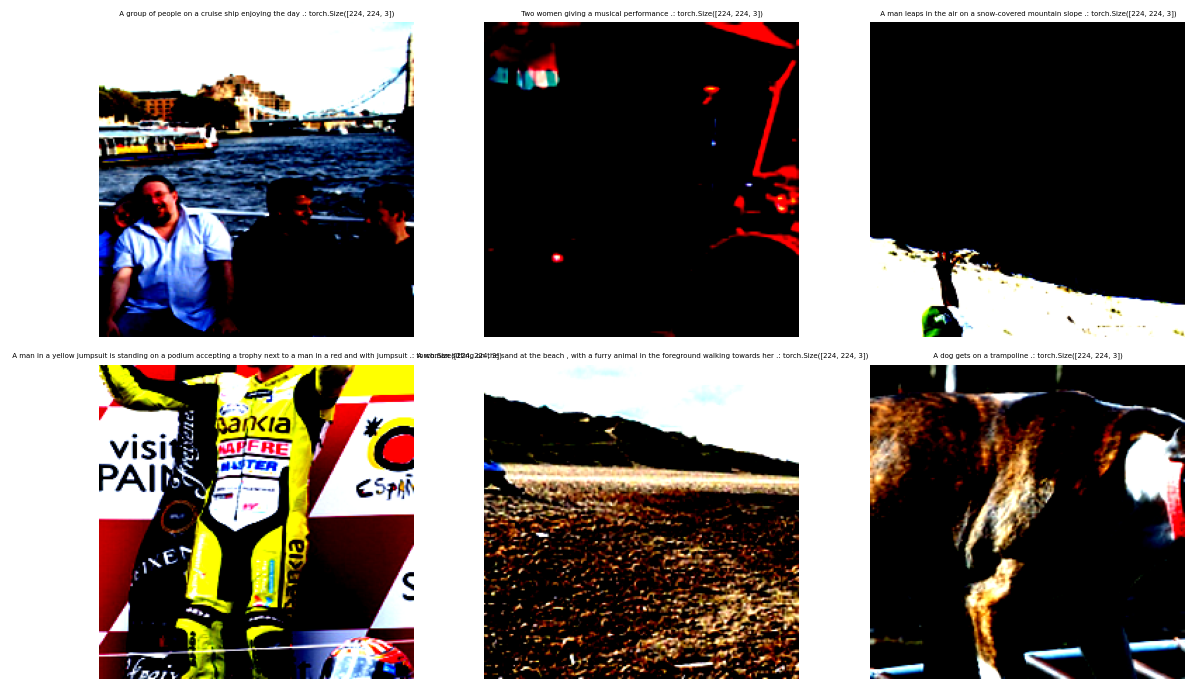

In [14]:
class DataHandler:
    """This class is responsible for loading and handling the data for CLIP."""

    def __init__(self, dataset_path: Path = DATASET_ROOT, valid_ratio: float = 0.1) -> None:
        
        # Paths to the Dataset Files
        self.local_path = dataset_path
        self.caption_path = self.local_path / "results.csv"
        
        # Downloading the Dataset if not Exists
        if not self.local_path.exists():
            print("Dataset doesn't exist, consider adding the dataset to path.")
        else:
            print("Dataset already exists, Skipping Download.")

        # Checking for the Captions if not Exists
        if not self.caption_path.exists():
            print("Missing Captions CSV, Please Download it from Kaggle.")
        else:
            print("Captions exist, proceeding to dataset construction.")

        # Transforms Based on Mode
        self.train_transforms = v2.Compose([
            v2.Resize(size=256, interpolation=v2.InterpolationMode.BICUBIC),
            v2.RandomResizedCrop(size=(224, 224), antialias=True),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
        ])

        self.test_transforms = v2.Compose([
            v2.Resize(size=256, interpolation=v2.InterpolationMode.BICUBIC),
            v2.CenterCrop(size=(224, 224)),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
        ])
        
        # Creating the split for the dataset
        self.full_captions_df = pd.read_csv(self.caption_path, sep="|", encoding="utf-8")
        n_unique_images = self.full_captions_df["image_name"].nunique()
        
        # Calculating the sizes of the splits
        valid_len = int(n_unique_images * valid_ratio)

        # Retrieving the Random Indices for the splits
        full_shuffled_indices = torch.randperm(n=n_unique_images)
        self.train_idx = full_shuffled_indices[:n_unique_images - valid_len]
        self.valid_idx = full_shuffled_indices[n_unique_images - valid_len:]

    def construct_dataset(self, batch_size: int = 64) -> tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
        """Constructs and loads the preprocessed, transformed and batched dataset."""

        # Constructing the Splits
        self.train_dataset = Flickr30Dataset(
            root_dir=self.local_path, df=self.full_captions_df, transforms=self.train_transforms, idx=self.train_idx
        )
        self.valid_dataset = Flickr30Dataset(
            root_dir=self.local_path, df=self.full_captions_df, transforms=self.test_transforms, idx=self.valid_idx
        )
        
        # Loading an Iterable for the Splits
        loaded_train_dataset = torch.utils.data.DataLoader(
            self.train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True
        )
        loaded_valid_dataset = torch.utils.data.DataLoader(
            self.valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True
        )

        return loaded_train_dataset, loaded_valid_dataset


# Testing
data_handle = DataHandler()
data_handle.construct_dataset()
data_handle.train_dataset.show_sample_image_text_pairs()

## Training Handler

In [15]:
class TrainingLoop:
    """This class handles the training loop for the models."""
    def __init__(self, learning_rate: float, model: torch.nn.Module):
        
        # Loading the Model Instance for the Training Loop
        self.model = model

        # Optimizer
        self.optim = torch.optim.AdamW(
            params=self.model.parameters(),
            lr=learning_rate
        )

        # Accelerator Device
        self.device = torch.accelerator.current_accelerator()

        # Learning Rate Scheduler
        self.lr_schedule = ReduceLROnPlateau(
            optimizer=self.optim, mode="min", patience=5, min_lr=1e-6
        )

        # Creating the Checkpoint Storage Directory
        self.model_dir = Path(CHECKPOINT_PATH)
        if not self.model_dir.exists():
            self.model_dir.mkdir()
    
    def train_model(
            self, epochs: int,
            train_set: DataLoader, valid_set: DataLoader
        ) -> tuple[list[float], list[float]]:
        """Trains the model for the given number of epochs."""

        # Cache Losses
        train_losses = []
        valid_losses = []

        # Mean Training Variables
        mean_loss_train = 0
        mean_loss_valid = 0

        # Training Checkpoint
        best_valid_loss = torch.inf
        patience = 7
        patience_counter = 0

        # Loss Function
        loss_fn = torch.nn.CrossEntropyLoss()

        # Training Loop
        print("The training process has started")
        for i in range(epochs):

            # Average Epoch Time tracking
            start = time.time()

            # ==== Training Step ====

            # Completing a single epoch
            for batch in train_set:

                # Moving the batches to GPU
                image_batch = batch["image"].to(self.device)
                text_batch = batch["caption"]
            
                # Training Step
                logits = self.model(image_batch, text_batch)

                # Constrastive Learning Labels: Indices of the respective encoder encodings
                labels = torch.arange(logits.shape[0], device=self.device)

                # Loss Calculation
                image_to_text_loss = loss_fn(logits, labels)
                text_to_image_loss = loss_fn(logits.T, labels)
                train_loss = (image_to_text_loss + text_to_image_loss) / 2.0
                mean_loss_train += train_loss.item()

                # Backpropagation
                self.optim.zero_grad()
                train_loss.backward()
                self.optim.step()

            # Completion of Epoch
            end = time.time()

            # ==== Validation Step ====

            # Turning on the Eval mode on the model for the BN-Layers
            self.model.eval()
            with torch.no_grad():
                for batch in valid_set:

                    # Moving the batches to GPU
                    image_batch = batch["image"].to(self.device)
                    text_batch = batch["caption"]

                    # Validation Calculation
                    logits = self.model(image_batch, text_batch)

                    # Constrative Learning Labels
                    labels = torch.arange(logits.shape[0], device=self.device)

                    # Loss Calculation
                    image_to_text_loss = loss_fn(logits, labels)
                    text_to_image_loss = loss_fn(logits.T, labels)
                    valid_loss = (image_to_text_loss + text_to_image_loss) / 2.0
                    mean_loss_valid += valid_loss.item()
            
            # Switching the model back to training mode
            self.model.train()

            # ==== End of Epoch Metrics & Model Checkpointing ====
            mean_loss_train /= len(train_set)
            mean_loss_valid /= len(valid_set)
            time_epoch = end - start

            # Update the LR-Schedule
            self.lr_schedule.step(mean_loss_valid)

            # Updating the Caches
            train_losses.append(mean_loss_train)
            valid_losses.append(mean_loss_valid)

            print(f"Epoch {i + 1}: Train Loss -> {mean_loss_train} | Valid Loss -> {mean_loss_valid} | Time Epoch -> {time_epoch}")

            # Updating the best validation loss so far
            if mean_loss_valid < best_valid_loss:
                best_valid_loss = mean_loss_valid

                # Saving the Model by weights
                torch.save(obj=self.model.state_dict(), f=self.model_dir / "clip.pth")
                print("New best model was saved")
                patience_counter = 0
            else:
                patience_counter += 1
                print(f"No improvement: {patience_counter} / {patience}")
                if patience_counter >= patience:
                    print("Early Stopping")
                    break

            # ==== Reset the Training Loop Metrics ====
            mean_loss_train, mean_loss_valid = 0, 0
        
        return train_losses, valid_losses

## Training Parameters

In [16]:
BATCH_SIZE = 64
EPOCHS = 25
LEARNING_RATE = 1e-4

## The Main Function

Hello, CLIP
Dataset already exists, Skipping Download.
Captions exist, proceeding to dataset construction.
Len of Train Indices:  torch.Size([28605])
Len of Valid Indices:  torch.Size([3178])
Len of Train Dataset:  28605
Len of Valid Dataset:  3178
No of Batches in Train Loaded:  446  ->  28544
No of Batches in Valid Loaded:  49  ->  3136
The training process has started
Epoch 1: Train Loss -> 4.15903779850947 | Valid Loss -> 4.158872954699458 | Time Epoch -> 787.735734462738
New best model was saved
Epoch 2: Train Loss -> 4.15897776620805 | Valid Loss -> 4.15868177219313 | Time Epoch -> 790.1925337314606
New best model was saved
Epoch 3: Train Loss -> 4.158798009290823 | Valid Loss -> 4.158880535437136 | Time Epoch -> 789.6758859157562
No improvement: 1 / 7
Epoch 4: Train Loss -> 4.158877544873499 | Valid Loss -> 4.158773276270653 | Time Epoch -> 789.0927319526672
No improvement: 2 / 7
Epoch 5: Train Loss -> 4.158709986862045 | Valid Loss -> 4.158875844916519 | Time Epoch -> 788.74564

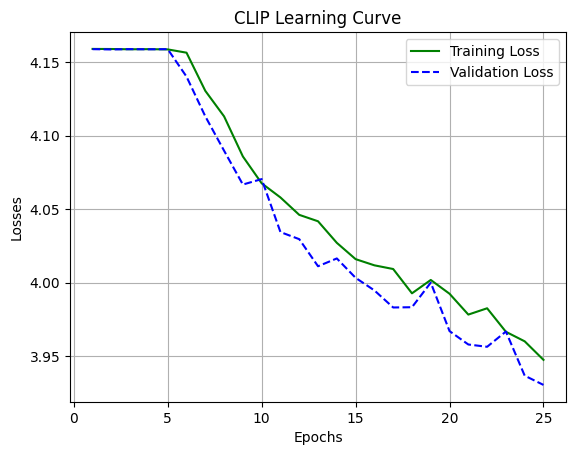

In [17]:
# The Main Function
def main() -> None:
    print("Hello, CLIP")
    
    # Loading the Data Handler
    data_handle = DataHandler()

    # Viewing the sizes of the indices for Training and Validation Splits
    print("Len of Train Indices: ", data_handle.train_idx.shape)
    print("Len of Valid Indices: ", data_handle.valid_idx.shape)

    loaded_train, loaded_valid = data_handle.construct_dataset(batch_size=BATCH_SIZE)
    print("Len of Train Dataset: ", len(data_handle.train_dataset))
    print("Len of Valid Dataset: ", len(data_handle.valid_dataset))

    print("No of Batches in Train Loaded: ", len(loaded_train), " -> ", len(loaded_train) * BATCH_SIZE)
    print("No of Batches in Valid Loaded: ", len(loaded_valid), " -> ", len(loaded_valid) * BATCH_SIZE)

    # Initialising the CLIP model
    base_model = CLIP().to(DEVICE)
    clip = torch.nn.DataParallel(base_model)

    # Initialsing the Training Loop
    optimizer = TrainingLoop(learning_rate=LEARNING_RATE, model=clip)

    # Training the Model
    train_losses, valid_losses = optimizer.train_model(
        epochs=EPOCHS, train_set=loaded_train, valid_set=loaded_valid
    )

    # Plotting the Chart
    ASSETS.mkdir(exist_ok=True)

    plt.title("CLIP Learning Curve")
    plt.plot(range(1, len(train_losses) + 1), train_losses, c="g", ls="-", label="Training Loss")
    plt.plot(range(1, len(train_losses) + 1), valid_losses, c="b", ls="--", label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.legend(loc="upper right")
    plt.grid()
    plt.savefig(ASSETS / "clip_learning_curve.jpg")
    plt.show()


# Driver code
if __name__ == "__main__":

    # The Main Function
    main()